In [43]:
import scipy.optimize as scopt
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [44]:
f = scopt.rosen
grad = scopt.rosen_der
hess = scopt.rosen_hess

In [45]:
def newton_minimize(f, gradf, hessf, x0, alpha, num_iter):
    x = x0.copy()
    conv = [x]
    for i in range(num_iter):
        H = hessf(x)
        g = gradf(x)
        x = x - alpha * jnp.linalg.solve(H, g)
        conv.append(x)
    return x, conv

In [80]:
def grad_descent(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    conv = [x]
    for i in range(num_iter):
        h = -grad(x)
        if np.linalg.norm(h) < eps:
            break
        x = x + alpha * h
        conv.append(x)
    return x, conv

def heavy_ball(f, grad, x0, num_iter, eps, alpha, beta):
    x = x0.copy()
    conv = [x]
    prev_x = None
    for i in range(num_iter):
        h = -grad(x)
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = x + alpha * h
        else:
            x, prev_x = x + alpha * h + beta * (x - prev_x), x
            
        conv.append(x)
    return x, conv


def accelerated_gd(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    y = x0.copy()
    conv = [x]
    prev_x = None
    for i in range(num_iter):
        h = -grad(y)
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = y + alpha * h
        else:
            x, prev_x = y + alpha * h, x
        
        y = x + (i+1.) / (i+4.) * (x - prev_x)
            
        conv.append(x)
    return x, conv

def accelerated_gd_restart(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    y = x0.copy()
    conv = [x]
    prev_x = None
    for i in range(num_iter):
        h = -grad(y)
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = y + alpha * h
        else:
            x, prev_x = y + alpha * h, x
        if f(x) < f(prev_x):
            y = x + (i+1.) / (i+4.) * (x - prev_x)
        else:
            y = prev_x.copy()
            prev_x = None
            
        conv.append(x)
    return x, conv

In [118]:
n = 100
x_star = jnp.ones(n)
f(x_star)

0.0

In [135]:
x0 = jnp.ones(n) + 1. * jnp.array(np.random.randn(n))
num_iter = 7000
tol = 1e-5
alpha = 1e-4

In [136]:
_, conv_newton = newton_minimize(f, grad, hess, x0, 1e-1, num_iter)
_, conv_gd = grad_descent(f, grad, x0, num_iter, tol, alpha)
_, conv_hb = heavy_ball(f, grad, x0, num_iter, tol, alpha, 0.9)
_, conv_acc = accelerated_gd(f, grad, x0, num_iter, tol, alpha)
_, conv_acc_restart = accelerated_gd_restart(f, grad, x0, num_iter, tol, alpha)

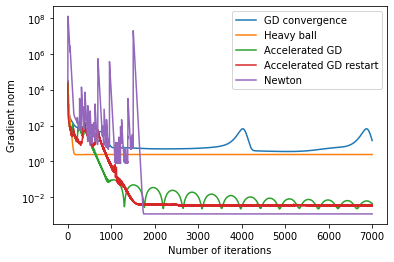

In [137]:
plt.semilogy([np.linalg.norm(grad(x)) for x in conv_gd], label="GD convergence")
plt.semilogy([np.linalg.norm(grad(x)) for x in conv_hb], label="Heavy ball")
plt.semilogy([np.linalg.norm(grad(x)) for x in conv_acc], label="Accelerated GD")
plt.semilogy([np.linalg.norm(grad(x)) for x in conv_acc_restart], label="Accelerated GD restart")
plt.semilogy([np.linalg.norm(grad(x)) for x in conv_newton], label="Newton")
plt.xlabel("Number of iterations")
plt.ylabel("Gradient norm")
plt.legend()

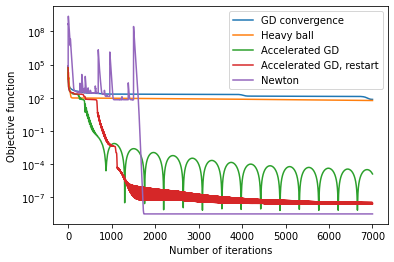

In [138]:
plt.semilogy([f(x) for x in conv_gd], label="GD convergence")
plt.semilogy([f(x) for x in conv_hb], label="Heavy ball")
plt.semilogy([f(x) for x in conv_acc], label="Accelerated GD")
plt.semilogy([f(x) for x in conv_acc_restart], label="Accelerated GD, restart")
plt.semilogy([f(x) for x in conv_newton], label="Newton")
plt.xlabel("Number of iterations")
plt.ylabel("Objective function")
plt.legend()

In [123]:
%timeit newton_minimize(f, grad, hess, x0, 1e-3, 100)
%timeit accelerated_gd(f, grad, x0, 100, tol, alpha)

10 loops, best of 5: 42 ms per loop
100 loops, best of 5: 5.56 ms per loop
